In [1]:
""" IMPORTS """
import yfinance as yf
import numpy as np
import seaborn
import pandas as pd
import scipy
import random
import scipy.optimize as sco
import matplotlib.pyplot as plt
import seaborn
from matplotlib.pyplot import figure
from scipy import stats
from scipy.stats import norm
from IPython.display import display

In [3]:
""" Downloading companies' data from yahoo finance """
stocks_data = yf.download('AAPL ADDYY AXP COP COST CVS DVA FB GD GM IBM INTC JNJ JPM KO MA MCO MTB NKE PG PLTR USB V WFC WMT',
                          start="2012-01-01")

[*********************100%***********************]  25 of 25 completed


In [20]:
"""
    Computing annualized mean, annualized volatility and Sharpe ratio
"""
def annualized_mean(x):
    annualized_mean = x.mean() * 252 # mean times number of trading days in a year
    return annualized_mean
def annualized_vol(x):
    annualized_vol = x.std() * np.sqrt(252) # standard deviation times square of the number of trading days in a year
    return annualized_vol
def annualized_sharpe(x):
    annualized_sharpe = annualized_mean(x)/annualized_vol(x) # annualized mean divided by annualized volatility
    return annualized_sharpe

In [26]:
""" Future weights for the portfolio stocks """
weights = np.array([1/25, 1/25, 1/25, 1/25, 1/25, 1/25, 1/25, 1/25, 1/25, 1/25, 1/25, 1/25, 1/25, 1/25,
                   1/25, 1/25, 1/25, 1/25, 1/25, 1/25, 1/25, 1/25, 1/25, 1/25, 1/25]) 

mean_data = (stocks_data['Close'].pct_change()*weights).sum(axis=1).resample("Y").apply(annualized_mean).mean()
print(f"Portfolio's returns' annualized mean : {round(mean_data*100, 2)}%")

vol_data = (stocks_data['Close'].pct_change()*weights).sum(axis=1).resample("Y").apply(annualized_vol).mean()
print(f"Portfolio's returns' annualized volatility : {round(vol_data*100, 2)}%")

sharpe_data = (stocks_data['Close'].pct_change()*weights).resample("Y").apply(annualized_sharpe).mean()
print(f'Ratio de Sharpe portfolio {round(sharpe_data.mean(), 2)}')

Portfolio's returns' annualized mean : 12.05%
Portfolio's returns' annualized volatility : 14.77%
Ratio de Sharpe portfolio 0.62


In [27]:
""" Class for statistical data analysis """
class MyStatIndicator:

    """ Class constructor builds new object """
    def __init__(self, dataframe, returns=False):
        self.data = (dataframe if returns else dataframe.pct_change())
        
    """ Daily returns moving average """
    def rollMean(self, period):
        return self.data.rolling(window=period, min_periods=period).mean() * period

    """ Daily returns variance """
    def rollVar(self, period):
        return self.data.rolling(window=period, min_periods=period).var() * period

    """ Daily returns covariance """
    def rollCov(self, period, normalized=True):
        divisor = (self.data.rolling(window=period, min_periods=period).std() ** 2) 
        return self.data.rolling(window=period, min_periods=period).cov() / (divisor if normalized else 1)

    """ Daily returns correlation """
    def rollCorr(self, period):
        return self.data.rolling(window=period, min_periods=period).corr()

    """ Daily returns volatility """
    def rollVol(self, period):
        return np.sqrt(rollVar(self.data, period))

    """ Daily returns Sharpe ratio """
    def rollSharpe(self, period):
        return rollMean(self.data, period) / rollVol(self.data, period)
    
    """ 
    Value @ risk parameters :
    - stock portfolio weigths
    - Percentiles (levels of confidence) 
    - initial investment 
    """
    def VaR(self, weights, VaR_level=0.05, investment = 1000000):
        self.data
        
        # Portfolio
        ptf = (self.data * weights).sum(axis=1) # sum of values multiplied by weights
        ptf.mean() # returns expected value
        
        # Compute PTF statistics
        cov_matrix = self.data.cov()
        avg_rets = self.data.mean()
        ptf_mean = avg_rets.dot(weights)
        ptf_std  = np.sqrt(weights.T.dot(cov_matrix).dot(weights)) 

        # normal distribution percentage point function to compute the loss on initial investment
        cutoff = stats.norm.ppf(VaR_level, ptf_mean, ptf_std)

        print('With {}% confidence that our portfolio will not exceed losses greater than {:0.2f} of investment over a one day period.'.format(100*(1-VaR_level), -cutoff*investment))
        
        var_array = []
        for x in range(1, 6):
            var_array.append(-cutoff * np.sqrt(x))

        """ Plot """
        plt.xlabel("Day #")
        plt.ylabel("Max portfolio loss")
        plt.title(f"V@R over 5-day period var_level = {VaR_level}")
        plt.plot(var_array, "r")
        return cov_matrix

In [28]:
period = 252
statistics = MyStatIndicator(stocks_data['Close'])

In [29]:
""" Returns moving average from the last 252 trading days """
rollMean = statistics.rollMean(period) 
stocks_rollMean = pd.DataFrame(rollMean) 
print(stocks_rollMean.tail(3))

""" Returns moving variance from the last 252 trading days """
rollVar = statistics.rollVar(period) 
stocks_rollVar = pd.DataFrame(rollVar) 
print(stocks_rollVar.tail(3))

""" Returns covariance from the last 252 trading days """
rollCov = statistics.rollCov(period)
stocks_rollCov = pd.DataFrame(rollCov) 
print(stocks_rollCov.tail(25))

""" Returns correlation from the last 252 trading days """
rollCorr = statistics.rollCorr(period)
stocks_rollCorr = pd.DataFrame(rollCorr) 
print(stocks_rollCorr.tail(25))

""" Returns volatility from the last 252 trading days """
stocks_rollVol = np.sqrt(rollVar)
stocks_rollVol = pd.DataFrame(stocks_rollVol)
print(stocks_rollVol.tail(3))

""" Returns Sharpe ration from the last 252 trading days """
stocks_rollSharpe = stocks_rollMean/stocks_rollVol 
stocks_rollSharpe = pd.DataFrame(stocks_rollSharpe)
print(stocks_rollSharpe.tail(3))

                AAPL     ADDYY       AXP       COP      COST       CVS  \
Date                                                                     
2022-02-09  0.294540 -0.153766  0.466610  0.736990  0.415789  0.374253   
2022-02-10  0.272862 -0.220878  0.461455  0.742945  0.407225  0.382426   
2022-02-11  0.250867 -0.258175  0.432320  0.744958  0.388671  0.363883   

                 DVA        FB        GD        GM  ...        MA       MCO  \
Date                                                ...                       
2022-02-09  0.032791 -0.069615  0.292001 -0.010056  ...  0.174002  0.237582   
2022-02-10  0.020304 -0.081111  0.271844  0.007598  ...  0.129788  0.251160   
2022-02-11  0.095330 -0.118874  0.273991 -0.024267  ...  0.122901  0.200144   

                 MTB       NKE        PG      PLTR       USB         V  \
Date                                                                     
2022-02-09  0.292903  0.063922  0.229587 -0.778572  0.266274  0.145014   
2022-02-10 

Building a balanced portfolio of 25 stocks and perform the same statistical analysis as well as a V@R analysis at the 1%, 2%, 3%, 4% and 5% percentiles and at the 1-day, 2-day, 3-day, 4-day, 5-day investment horizons

In [30]:
ptf = stocks_data
returns_ptf = ptf['Close'].pct_change()

With 99.0% confidence that our portfolio will not exceed losses greater than 23960.64 of investment over a one day period.
With 98.0% confidence that our portfolio will not exceed losses greater than 21074.31 of investment over a one day period.
With 97.0% confidence that our portfolio will not exceed losses greater than 19243.02 of investment over a one day period.
With 96.0% confidence that our portfolio will not exceed losses greater than 17865.42 of investment over a one day period.
With 95.0% confidence that our portfolio will not exceed losses greater than 16744.84 of investment over a one day period.


,AAPL,ADDYY,AXP,COP,COST,CVS,DVA,FB,GD,GM,...,MA,MCO,MTB,NKE,PG,PLTR,USB,V,WFC,WMT
AAPL,0.000320,0.000093,0.000117,0.000118,0.000086,0.000076,0.000085,0.000169,8.616422e-05,0.000119,...,0.000151,0.000141,0.000095,0.000108,0.000066,2.073954e-04,0.000100,0.000132,0.000108,0.000064
ADDYY,0.000093,0.000319,0.000132,0.000120,0.000053,0.000062,0.000063,0.000104,8.847041e-05,0.000132,...,0.000121,0.000123,0.000112,0.000114,0.000048,8.489240e-05,0.000108,0.000107,0.000118,0.000035
AXP,0.000117,0.000132,0.000323,0.000215,0.000063,0.000109,0.000110,0.000112,1.437073e-04,0.000211,...,0.000189,0.000164,0.000223,0.000130,0.000066,3.670158e-05,0.000208,0.000172,0.000219,0.000050
COP,0.000118,0.000120,0.000215,0.000501,0.000053,0.000103,0.000097,0.000114,1.394646e-04,0.000217,...,0.000168,0.000153,0.000210,0.000114,0.000063,1.111933e-04,0.000200,0.000149,0.000218,0.000045
COST,0.000086,0.000053,0.000063,0.000053,0.000149,0.000071,0.000060,0.000075,5.857609e-05,0.000063,...,0.000080,0.000092,0.000055,0.000072,0.000060,5.924358e-05,0.000062,0.000075,0.000067,0.000080
CVS,0.000076,0.000062,0.000109,0.000103,0.000071,0.000223,0.000097,0.000064,9.210288e-05,0.000099,...,0.000089,0.000092,0.000109,0.000075,0.000065,-4.136672e-05,0.000106,0.000087,0.000115,0.000072
DVA,0.000085,0.000063,0.000110,0.000097,0.000060,0.000097,0.000284,0.000074,8.590161e-05,0.000102,...,0.000101,0.000099,0.000103,0.000071,0.000055,-7.374915e-06,0.000099,0.000090,0.000107,0.000053
FB,0.000169,0.000104,0.000112,0.000114,0.000075,0.000064,0.000074,0.000564,8.631767e-05,0.000120,...,0.000161,0.000145,0.000085,0.000116,0.000052,2.479903e-04,0.000097,0.000148,0.000098,0.000048
GD,0.000086,0.000088,0.000144,0.000139,0.000059,0.000092,0.000086,0.000086,1.860027e-04,0.000138,...,0.000121,0.000121,0.000144,0.000095,0.000056,2.657583e-07,0.000135,0.000110,0.000140,0.000048
GM,0.000119,0.000132,0.000211,0.000217,0.000063,0.000099,0.000102,0.000120,1.384148e-04,0.000434,...,0.000155,0.000155,0.000200,0.000130,0.000052,1.650948e-04,0.000185,0.000139,0.000200,0.000045


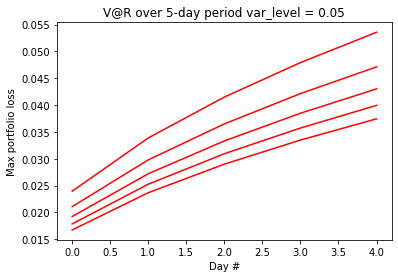

In [31]:
""" Computing Value @ Risk for a balanced portfolio """
statistics_ptf = MyStatIndicator(ptf['Close'])

weights = np.array([1/25, 1/25, 1/25, 1/25, 1/25, 1/25, 1/25, 1/25, 1/25, 1/25, 1/25, 1/25, 1/25, 1/25,
                   1/25, 1/25, 1/25, 1/25, 1/25, 1/25, 1/25, 1/25, 1/25, 1/25, 1/25])

initial_investment = 1000000

VaR_level = [.01, .02, .03, .04, .05]
for i in range(len(VaR_level)):
    cov_matrix = statistics_ptf.VaR(weights, VaR_level[i], initial_investment)
    cov_matrix
display(cov_matrix)

Computing the optimal weights using the Markovitz method for each year

[*********************100%***********************]  25 of 25 completed
Tangent Portfolio
----------------------------------------------------
Return:   0.34328855600995956
Volatility:  0.2705105955418645
Sharpe ratio:  1.2690392231118055

AAPL    0.1630609989928022
ADDYY    -0.00658981899659804
AXP    0.09613488404393383
COP    -0.0625774153226974
COST    0.12166266237636589
CVS    -0.030928221478935328
DVA    0.04937120345648225
FB    0.17034365328994533
GD    0.19103861585279577
GM    0.07771331167045499
IBM    -0.08223485110814549
INTC    -0.03176306255556053
JNJ    -0.06820904778707024
JPM    0.2157798223116485
KO    0.11143736107257356
MA    0.10903579868018336
MCO    0.04791503129278893
MTB    -0.08602345728496257
NKE    0.20892957170947954
PG    -0.22344703991771603
PLTR    0.18726415862960352
USB    -0.1588278861260051
V    0.10241668096439939
WFC    -0.08287524845514747
WMT    -0.018627705310618633




Portfolio Global Minimum Variance
-----------------------------------------

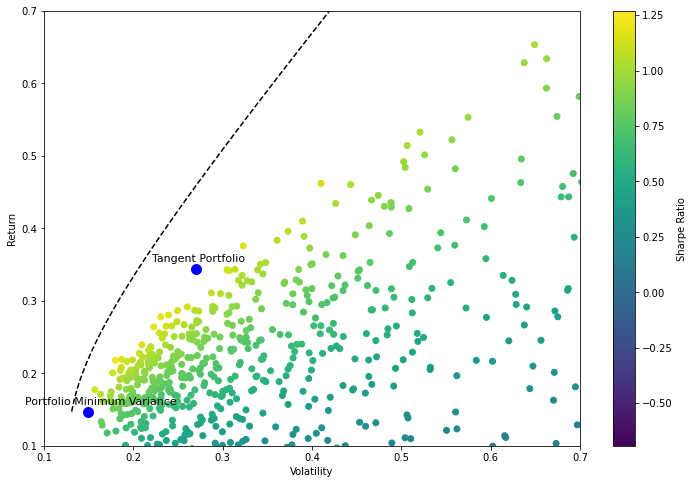

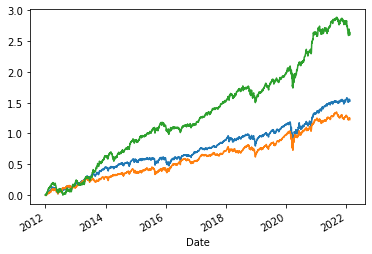

In [32]:
"""
    Class to find the analytical solution of the Markowitz efficient portfolio.
    Markowitz is a method that consists in finding the weights of the securities that will allow to create
    a portfolio with maximum efficiency: maximum return for minimum risk.
"""
class MarkovitzOptimizer:
    @staticmethod
    def portfolio_volatility(weights, mean_returns, cov):
            return np.sqrt(np.dot(weights.T, np.dot(cov, weights))) 
    
    """ Constructor """
    def __init__(self, portfolio, trials = 1000, daycount = 252):
        self.ptf = portfolio
        return_annual = self.ptf.pct_change().mean() * daycount
        cov_annual = self.ptf.pct_change().cov() * daycount
        zbar = np.array(return_annual) 
        S = np.array(cov_annual)

        all_weights = np.zeros((trials, len(zbar)))
        ret_arr = np.zeros(trials) 
        vol_arr = np.zeros(trials)
        sharpe_arr = np.zeros(trials)

        for x in range(trials): 
            weights = 2*np.array(np.random.random(len(zbar)))-1. # creates pseudo random weights
            weights = weights/np.sum(weights)
            # Save weights
            all_weights[x,:] = weights
            # Expected return
            ret_arr[x] = np.sum(zbar * weights)
            # Expected volatility
            vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(S, weights)))
            # Sharpe Ratio
            sharpe_arr[x] = ret_arr[x]/vol_arr[x]

            max_ret=ret_arr[sharpe_arr.argmax()] 
            max_vol=vol_arr[sharpe_arr.argmax()] 
            w_max  =all_weights[sharpe_arr.argmax()]

            min_ret=ret_arr[vol_arr.argmin()]
            min_vol=vol_arr[vol_arr.argmin()]
            w_min  =all_weights[vol_arr.argmin()]

        print("Tangent Portfolio")
        print("----------------------------------------------------")
        print("Return:  ", max_ret )
        print("Volatility: ", max_vol )
        print("Sharpe ratio: ", max_ret / max_vol )
        print()
        for i in range(len(self.ptf.columns)):
            print(str(self.ptf.columns[i]) + "    " + str(w_max[i]))
        print("\n\n\n")

        print("Portfolio Global Minimum Variance")
        print("----------------------------------------------------")
        print("Return:  ", min_ret )
        print("Volatility: ", min_vol )
        print("Sharpe ratio: ", min_ret / min_vol ) 
        print()
        for i in range(len(self.ptf.columns)):
            print(str(self.ptf.columns[i]) + "    " + str(w_min[i]))    
        print("\n\n\n")

        rp_min = min_ret
        target_returns = np.linspace(rp_min, 0.70, 100) # crée intervalle de valeurs entre les rendements les plus bas et 0.70
        num_assets = len(zbar)
        args = (return_annual,cov_annual) 

        efficient_portfolios = []
        for rr in target_returns:
            constraints = ({'type': 'eq', 'fun': lambda x: np.sum(return_annual*x) - rr},
                           {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
            bounds = tuple((-10,10) for asset in range(num_assets))
            efficient_portfolios.append(sco.minimize(MarkovitzOptimizer.portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints))

        # Plot
        plt.figure(figsize=(12,8))
        plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
        plt.colorbar(label='Sharpe Ratio')
        plt.xlabel('Volatility')
        plt.ylabel('Return')

        plt.plot([p['fun'] for p in efficient_portfolios], target_returns, linestyle='--', color='black', label='efficient frontier')

        plt.scatter(max_vol, max_ret,c='blue', s=100)
        plt.scatter(min_vol, min_ret,c='blue', s=100)

        plt.text(max_vol-0.05, max_ret+0.01,"Tangent Portfolio", color='black', fontsize=11) 
        plt.text(min_vol-0.07, min_ret+0.01,"Portfolio Minimum Variance", color='black', fontsize=11) 

        plt.xlim(0.10, 0.70)
        plt.ylim(0.10, 0.70)

        plt.show()
        pd.DataFrame(ptf.pct_change() / 25).sum(axis=1).cumsum().plot() # blue series
        pd.DataFrame(ptf.pct_change() * w_min).sum(axis=1).cumsum().plot() # orange series
        pd.DataFrame(ptf.pct_change() * w_max).sum(axis=1).cumsum().plot() # green series

ptf = yf.download('AAPL ADDYY AXP COP COST CVS DVA FB GD GM IBM INTC JNJ JPM KO MA MCO MTB NKE PG PLTR USB V WFC WMT',
                          start="2012-01-01")['Close']

MarkovitzOptimizer(ptf)

Sur le graphique ci-dessus :
* la courbe bleue représente la série temporelle de la moyenne des rendements cumulés pour les actifs du portefeuille équi-pondéré en question.
* la courbe orange représente la série temporelle de la moyenne des rendements cumulés pour les actifs du portefeuille où les poids sont les valeurs pour lesquelles la volatilité est la plus faible.
* la courbe verte représente la série temporelle de la moyenne des rendements cumulés pour les actifs du portefeuille où les poids sont les valeurs pour lesquelles le ratio de Sharpe est le plus élevé. C'est à dire où le rapport entre les rendements annuels et la volatilité est le plus grand.

Markovitz suppose que l'investisseur est un agent rationnel averse au risque. 

"La méthode teste différentes combinaisons d'actifs avec des pondérations diverses pour calculer le risque et la rentabilité espérée d'un portefeuille" (ABC Bourse). 

Ce portefeuille optimisé a l’espérance de rendement la plus élevée parmi les portefeuilles qui ont la même variance de rentabilité que lui. Sur la frontière efficiente se situent les portefeuilles composés de titres offrant le meilleur rendement pour un certain niveau de risque.

Le portefeuille tangent est le portefeuille situé au point optimal de la fronitère.
Si on imagine une droite tangente qui passe par ce point, alors plus on descend sur la droite plus le portefeuille est composé d'actifs sans risque. Plus on remonte, plus la proportion en actifs sans risque dans le portefeuille diminue et celle en actifs risqués augmente (ABC Bourse).

In [17]:
""" Portefeuille optimisé avec Markovitw """
ptf = yf.download('AAPL ADDYY AXP COP COST CVS DVA FB GD GM IBM INTC JNJ JPM KO MA MCO MTB NKE PG PLTR USB V WFC WMT',
                          start="2012-01-01")
statistics_ptf = MyStatIndicator(ptf['Close']) # appelle la classe des indicateurs statistiques

weights = np.array([0.24133513817557503,-0.011196953257808746,0.21327851196693945,
                    -0.23710601667037848,0.2671393073402135,0.02880257074645045,-0.0004366603677443151,
                    -0.041919693600240955,-0.17943653679299343,-0.07946965309011271,
                    -0.16167477911840838,-0.12704612908485285,0.14568379221929778,0.22376027685112815,
                    -0.07647593230521234,0.11361757821766527,0.2815181463347533,0.2662513571501617,
                    0.064810532517312,0.24219197617083196,0.21396047151013356,-0.1840134233138304,
                    0.17381110871730943,-0.10364402515535097,-0.27374096516083796])
# attribue les futurs poids des actions du portefeuille

[*********************100%***********************]  25 of 25 completed


In [18]:
"""
    ComOn calcule, pour le portefeuille optimisé, dans l'ordre la moyenne annualisée, 
    la volatilité annualisée et le ratio de Sharpe
"""
mean_dataOpt = (ptf['Close'].pct_change()*weights).sum(axis=1).resample("Y").apply(annualized_mean).mean()
print(f"Portfolio's returns' annualized mean : {mean_dataOpt}%")

vol_dataOpt = (ptf['Close'].pct_change()*weights).sum(axis=1).resample("Y").apply(annualized_vol).mean()
print(f"Portfolio's returns' annualized volatility : {vol_dataOpt}%")

sharpe_dataOpt = (ptf['Close'].pct_change()*weights).resample("Y").apply(annualized_sharpe).mean()
print(f'Ratio de Sharpe portfolio optimisé {sharpe_dataOpt.mean()}')

Portfolio's returns' annualized mean : 0.18824422282141004%
Portfolio's returns' annualized volatility : 0.22240486938452697%
Ratio de Sharpe portfolio optimisé 0.12518902975927657


With 99.0% confidence that our portfolio will not exceed losses greater than 38490.76 of investment over a one day period.
With 98.0% confidence that our portfolio will not exceed losses greater than 33797.53 of investment over a one day period.
With 97.0% confidence that our portfolio will not exceed losses greater than 30819.83 of investment over a one day period.
With 96.0% confidence that our portfolio will not exceed losses greater than 28579.82 of investment over a one day period.
With 95.0% confidence that our portfolio will not exceed losses greater than 26757.74 of investment over a one day period.


,AAPL,ADDYY,AXP,COP,COST,CVS,DVA,FB,GD,GM,...,MA,MCO,MTB,NKE,PG,PLTR,USB,V,WFC,WMT
AAPL,0.000320,0.000093,0.000117,0.000118,0.000086,0.000076,0.000085,0.000169,8.616422e-05,0.000119,...,0.000151,0.000141,0.000095,0.000108,0.000066,2.073954e-04,0.000100,0.000132,0.000108,0.000064
ADDYY,0.000093,0.000319,0.000132,0.000120,0.000053,0.000062,0.000063,0.000104,8.847041e-05,0.000132,...,0.000121,0.000123,0.000112,0.000114,0.000048,8.489240e-05,0.000108,0.000107,0.000118,0.000035
AXP,0.000117,0.000132,0.000323,0.000215,0.000063,0.000109,0.000110,0.000112,1.437073e-04,0.000211,...,0.000189,0.000164,0.000223,0.000130,0.000066,3.670158e-05,0.000208,0.000172,0.000219,0.000050
COP,0.000118,0.000120,0.000215,0.000501,0.000053,0.000103,0.000097,0.000114,1.394646e-04,0.000217,...,0.000168,0.000153,0.000210,0.000114,0.000063,1.111933e-04,0.000200,0.000149,0.000218,0.000045
COST,0.000086,0.000053,0.000063,0.000053,0.000149,0.000071,0.000060,0.000075,5.857609e-05,0.000063,...,0.000080,0.000092,0.000055,0.000072,0.000060,5.924358e-05,0.000062,0.000075,0.000067,0.000080
CVS,0.000076,0.000062,0.000109,0.000103,0.000071,0.000223,0.000097,0.000064,9.210288e-05,0.000099,...,0.000089,0.000092,0.000109,0.000075,0.000065,-4.136672e-05,0.000106,0.000087,0.000115,0.000072
DVA,0.000085,0.000063,0.000110,0.000097,0.000060,0.000097,0.000284,0.000074,8.590161e-05,0.000102,...,0.000101,0.000099,0.000103,0.000071,0.000055,-7.374915e-06,0.000099,0.000090,0.000107,0.000053
FB,0.000169,0.000104,0.000112,0.000114,0.000075,0.000064,0.000074,0.000564,8.631767e-05,0.000120,...,0.000161,0.000145,0.000085,0.000116,0.000052,2.479903e-04,0.000097,0.000148,0.000098,0.000048
GD,0.000086,0.000088,0.000144,0.000139,0.000059,0.000092,0.000086,0.000086,1.860027e-04,0.000138,...,0.000121,0.000121,0.000144,0.000095,0.000056,2.657583e-07,0.000135,0.000110,0.000140,0.000048
GM,0.000119,0.000132,0.000211,0.000217,0.000063,0.000099,0.000102,0.000120,1.384148e-04,0.000434,...,0.000155,0.000155,0.000200,0.000130,0.000052,1.650948e-04,0.000185,0.000139,0.000200,0.000045


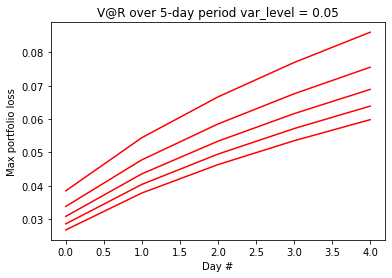

In [19]:
""" Computing Value @ Risk on optimized portfolio """
initial_investment = 1000000

VaR_level = [.01, .02, .03, .04, .05] # levels of confidance
for i in range(len(VaR_level)):
    marko_cov_matrix = statistics_ptf.VaR(weights, VaR_level[i], initial_investment)
    marko_cov_matrix
display(cov_matrix)

The portfolio optimized with the markovitz method has the best returns for a slightly higher volatility.

To get even better weights, we would have to increase the value of the 'trials' variable and perform more calculations. However, the disadvantage is that this requires more time (depending on the computing power of the machine used).

Advantages of Markovitz portfolios:
* the optimized portfolio can have the same expected returns with less risk
* the optimized portfolio can have better returns for the same level of risk
* diversification of assets within the portfolio (= risk reduction)

Limitations of the Markovitz method:
* past performance does not guarantee expected future results
* Impossible to determine VaR if the distribution is unknown
* Presupposes that markets are efficient and investors are rational
* Risk, return and correlation measures are based on expected values. These measures often cannot capture the true statistical characteristics of risk and return and do not account for new circumstances that did not exist when the historical data were generated.